# Introduction

In this notebook, we focus on a common text classification task, sentiment analysis.
which is challenging and far from being solved since languages are highly complex. It refers to analyzing an opinion or feelings about something using data like text for example. 

Sentiment analysis task is so important nowadays as it can help companies in their decision-making process. For instance, if public sentiment towards a product is not so good, a company may try to modify the product or stop the production in order to avoid any losses and vice versa; which explains the apparent increase of researches in this fields. 

This project is so about to extract sentiment, namely assign a category to an entire text or document. 
The most common verion of the sentiment analysis is a binary classification task where it is a question to classify tweets into two classes : positive and negative. However, in this project, we will consider the multi-classification task with three classes : neutral, positive and negative.  



We aim so to build a classification model to accurately classify text documents into a predefined category. The dataset consists of a collection of tweets in the form of text. Each row contains the text of a tweet and a sentiment label. A word or phrase drawn from the tweet (selected_text) are provided which encapsulates the provided sentiment. The original dataset is available here https://www.kaggle.com/c/tweet-sentiment-extraction/overview . 

In order to achieve this goal, I performed the following steps:

- Get/Load the dataset

- Explore and analyze the data

- Text preprocessing

- Build, train and evaluate the model

# Import Required librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Get/Load the dataset
Given tweets, the task is to predict whether a tweet contains positive, negative, or neutral sentiment. This is a typical supervised learning task where given a text string, we have to categorize the text string into predefined categories.


In [2]:
# Read csv
df =  pd.read_csv('train.csv')

In [3]:
# Take a look to the dataset
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


For Natural Language Preprocessing tasks, it is so important to explore the data, namely the text in order to implement strategies of text preprocessing.

In [4]:
# Randomly show 5 text
samples = [np.random.randint(len(df)) for i in range(5)]
for index in samples:
    print(df['text'][index])
    print()

 I would notice...

 Aye. Now I want cheesecake

 Yeah, mine said 'That`s a nice picture' & gave me the red x!  Hope you get it working soon!

colds nearly gone, yayness!! greys anatomy on tonight . . . . . .double yay!

 Getting back online, now. Just shifting locations!



We remark that for example http, number and punctuations are used which are not helpful to extract sentiment from text.

# Explore and analyze the data
Let's explore the dataset and try to extract any trends.

Let's first extract the different sentiments.

In [5]:
# Extract the different classes
print(f'There are {len(df.sentiment.unique())} classes in this dataset which are {df.sentiment.unique()}')

There are 3 classes in this dataset which are ['neutral' 'negative' 'positive']


Let's see if the dataset is balanced or unbalanced. 

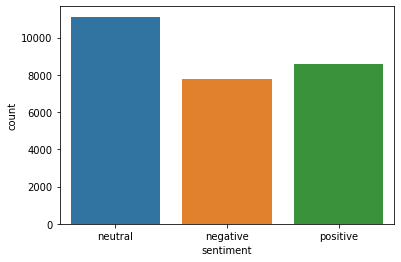

In [6]:
# Check for data imbalance
sns.countplot(data= df, x= 'sentiment');

In [7]:
# count the number of tweets for each classes
df.sentiment.value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [8]:
# get pourcentage of neutral, positive and negative tweets
df['sentiment'].value_counts(normalize=True)

neutral     0.404570
positive    0.312288
negative    0.283141
Name: sentiment, dtype: float64

One can remark that about (40%) the tweets are neutral, followed by positive tweets (31%), and then the negative ones (28%).

## Missing values treatment in the dataset

In [9]:
#Missing values in training set
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

The text and selected_text column have each one one row missing . Let's get rid of the missing rows.

In [10]:
# Dropping missing values
df.dropna(axis = 0, how ='any',inplace=True) ;

# Text preprocessing

Before we dive into extracting information out of words in text and selected text, let's first clean the data.

Preprocessing text is about :
- converting all letters to lower case
- removing numbers
- removing punctuations, accent marks and other useless characters
- removing extra spaces
- removing stop words, sparse terms, and particular words

Be careful : theses steps can be modified according the the dataset, languages and the project itself.

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
df['text'] = df['text'].apply(lambda x:clean_text(x))
df['selected_text'] = df['selected_text'].apply(lambda x:clean_text(x))

In [13]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative


# Build, train and evaluate models

We focus our attention in this part to Machine Learning NLP models to classify the tweets. 

The first step towards training a supervised machine learning NLP classifier is feature extraction. Indeed, we first have to transform each 'text' into a numerical representation in the form of a vector. One of the most frequently used approaches is to compute the frequency of a word in a predefined dictionary of words. For this purpose, we can explore vector representations such as Count_vectorizer or TF-IDF weighted vectors.
Having this vector representations of the text we can then train supervised classifiers. To this end, many different algorithms are available. In this project, we focus our attention to Naive Bayes method and Support Vector Machines (SVM).

First of all, let's split the dataset into two seperate part one for training and the second for evaluation.

In [14]:
# Split dataset into train and test sets
X_train, X_test, Y_train, Y_test, indices_train, indices_test = train_test_split(
    df['text'], df['sentiment'], df.index, test_size=0.25, random_state=3, stratify=df['sentiment'])

## Naive Bayes and Count_vectorizer


### Count_vectorizer

Text files are actually series of words. In order to run machine learning algorithms we need to convert the text files into numerical feature vectors. To this end, we use bag of words model. Briefly, we segment each text file into words (splitting by space), and count # of times each word occurs in each document and finally assign to each word an integer.

In [15]:
# Initialize count_vectorizer
count_vectorizer = CountVectorizer(min_df=5)

# create count_train and test variables 
count_train = count_vectorizer.fit_transform(X_train, Y_train)
count_test = count_vectorizer.transform(X_test)

Here, we set min_df = 5 for removing terms that appear in less than 5 documents.

 ### Naive Bayes classifier : Multinomial Naive Bayes (MNB)

The Naive Bayes classifier. It is a well_known machine learning classifier and some of the most popular text classification algorithms. It is a simple 'naïve' classification method based on Bayes rule. It relies on very simple representation of document namely bag of words. Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Despite its simplicity, it is able to achieve high performance on the task of classification. 

After converting a collection of text documents to a matrix of token counts using CountVectorizer, we will use  the Multinomial Naive Bayes (MNB) which is one of the members of the The Naive Bayes family.


In [16]:
# create a MultinomialNB model
count_nb = MultinomialNB()

# train model 
count_nb.fit(count_train, Y_train)

# run predict on your count test data to get your predictions 
count_nb_pred = count_nb.predict(count_test)

In [17]:
# evaluate the model
count_nb_accuracy_score = metrics.accuracy_score(count_nb_pred, Y_test)

print(str('{:04.2f}'.format(count_nb_accuracy_score*100))+'%')
print(classification_report(Y_test, count_nb_pred))


65.84%
              precision    recall  f1-score   support

    negative       0.66      0.61      0.63      1945
     neutral       0.61      0.67      0.64      2779
    positive       0.73      0.69      0.71      2146

    accuracy                           0.66      6870
   macro avg       0.67      0.66      0.66      6870
weighted avg       0.66      0.66      0.66      6870



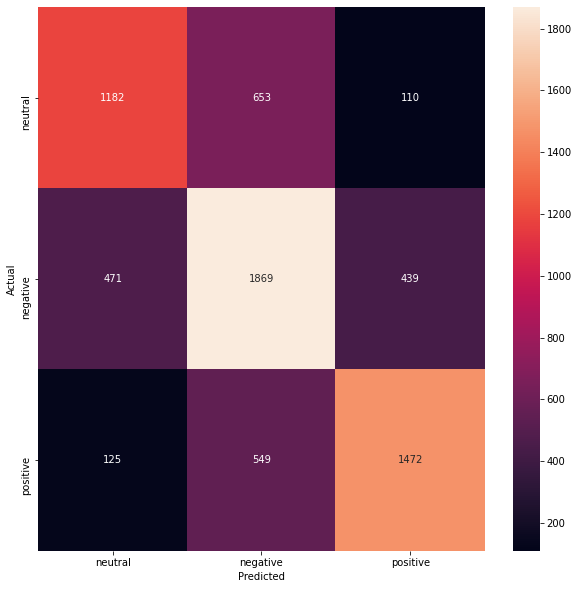

In [18]:
# Display the confusion matrix 
count_nb_conf_mat = confusion_matrix(Y_test, count_nb_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(count_nb_conf_mat, annot=True, fmt='d', xticklabels=df.sentiment.unique(), 
            yticklabels=df.sentiment.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Naive Bayes and Tfidf_Vectorizer

### TfidfVectorizer

Just counting the number of words in each document has an issue: it will give more weightage to longer documents than shorter documents.  To avoid this, we can use frequency TF which stands for Term Frequency. It measures how frequently a term occurs in a document i.e. #count(word) / #Total words, in each document. 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

In an other hand, IDF which stands for Inverse Document Frequency is equal to :

IDF(t) = log(Total number of documents / Number of documents with term t in it)

We multiply each of these terms TF and IDF to obtain TF-IDF which stands for Term Frequency-Inverse Document Frequency. It is a weight used to avaluate how important a word is to a document in a collection or corpus. We can even reduce the weightage of more common words like (the, is, an etc.) which occurs in all document.


Example:

Consider a document containing 100 words wherein the word dog appears 3 times. The term frequency (TF) for dog is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word dog appears in one thousand of these. Then, the inverse document frequency (IDF) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF features.

In [19]:
# initialize tfidf vectorizer 
tfidf_vectorizer = TfidfVectorizer(min_df=5)

# create count_train and test variables 
tfidf_train = tfidf_vectorizer.fit_transform(X_train, Y_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

Here, we set min_df = 5 for removing terms that appear in less than 5 documents.

 ### Naive Bayes classifier : Multinomial Naive Bayes (MNB)

After converting a collection of text documents to a matrix of token term frequency using TF-IDFtVectorizer, we use the Multinomial Naive Bayes (MNB) like the case of previous section. 

In [20]:
# create a MultinomialNB model
tfidf_nb = MultinomialNB()

# train model 
tfidf_nb.fit(tfidf_train, Y_train)

# run predict on your count test data to get your predictions 
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

In [21]:
# evaluate the model
tfidf_nb_accuracy_score = metrics.accuracy_score(tfidf_nb_pred, Y_test)

print(str('{:04.2f}'.format(tfidf_nb_accuracy_score*100))+'%')
print(classification_report(Y_test, tfidf_nb_pred))


64.75%
              precision    recall  f1-score   support

    negative       0.75      0.48      0.58      1945
     neutral       0.56      0.80      0.66      2779
    positive       0.77      0.60      0.67      2146

    accuracy                           0.65      6870
   macro avg       0.69      0.63      0.64      6870
weighted avg       0.68      0.65      0.64      6870



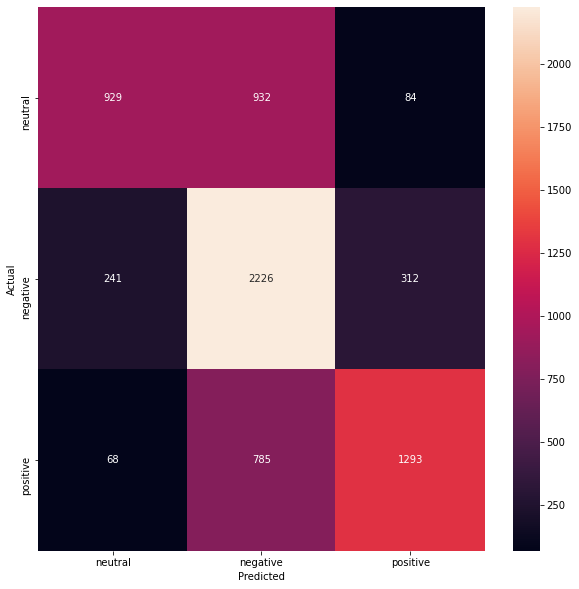

In [22]:
# Display the confusion matrix 
tfidf_nb_conf_mat = confusion_matrix(Y_test, tfidf_nb_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(tfidf_nb_conf_mat, annot=True, fmt='d', xticklabels=df.sentiment.unique(), 
            yticklabels=df.sentiment.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## LinearSVC and Tfidf_Vectorizer

A second category of machine learning NLP classifier is Support Vector Machines (SVM). SVM are supervised machine learning methods generally used for classification. SVMs are very efficient in high dimensional spaces. 
The main goal of SVMs is to divide the datasets into number of classes in order to find a maximum marginal hyperplane (MMH).

In order to improve the results of last sections, we will use LinearSVC which is one of the members of the the SVM family. 
LinearSVC stands for Linear Support Vector Classification. The aim of a Linear SVC is to fit the data, returning a "best fit" hyperplane that divides, or categorizes, your data. It performs well with a large number of samples.

In [23]:
# create a LinearSVC model
tfidf_svc = LinearSVC(random_state=6)

# train model 
tfidf_svc.fit(tfidf_train, Y_train)

# run predict on your count test data to get your predictions 
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

In [24]:
# evaluate the model
tfidf_svc_accuracy_score = metrics.accuracy_score(tfidf_svc_pred, Y_test)

print(str('{:04.2f}'.format(tfidf_svc_accuracy_score*100))+'%')
print(classification_report(Y_test, tfidf_svc_pred))

68.49%
              precision    recall  f1-score   support

    negative       0.68      0.62      0.65      1945
     neutral       0.64      0.70      0.67      2779
    positive       0.75      0.72      0.73      2146

    accuracy                           0.68      6870
   macro avg       0.69      0.68      0.69      6870
weighted avg       0.69      0.68      0.68      6870



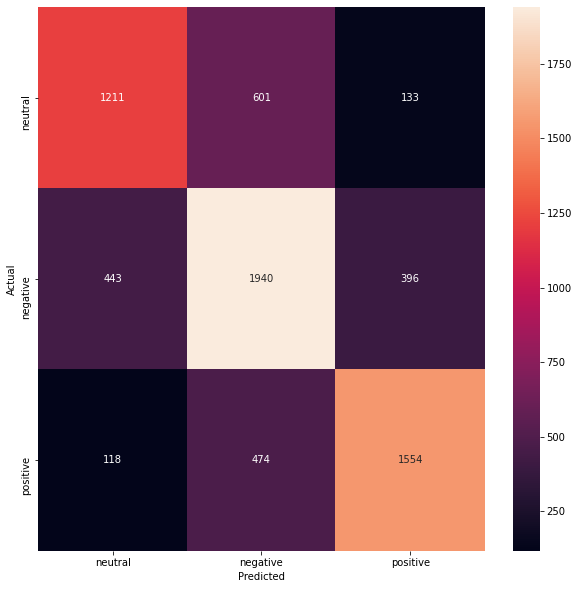

In [25]:
# Display the confusion matrix 
tfidf_svc_conf_mat = confusion_matrix(Y_test, tfidf_svc_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(tfidf_svc_conf_mat, annot=True, fmt='d', xticklabels=df.sentiment.unique(), 
            yticklabels=df.sentiment.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Conclusion
The sentiment analysis is one of the most commonly performed NLP tasks .

In this notebook, to perform sentiment analysis, we have been focusing on two categories of Machine Learning Classifier namely the Multinomial Naive Bayes algorithm and Linear SVC. We remark that LinearSVC outperforms the MultinomialNB with a gain of about 4%. One can consider other machine learning models like Random Forest, Logistic Regression genralized to multiple classes, KNeighbors or Decision Tree. 